In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
# загружаем цены
prices = pd.read_excel('~/notebooks/pqr/factors/monthlyprice.xlsx', index_col=0, parse_dates=True)
# загружаем данные по рыночной капитализации
mcap = pd.read_excel('~/notebooks/pqr/factors/mcap.xlsx', index_col=0, parse_dates=True)
# загружаем данные по среднему объему торгов за день
volume = pd.read_excel('~/notebooks/pqr/factors/betafilter.xlsx', index_col=0, parse_dates=True)
# загружаем бенчмарк
imoex = pd.read_excel('~/notebooks/pqr/factors/imoex.xlsx', index_col=0, parse_dates=True)

In [4]:
# приводим все таблицы к одинаковому формату
prices, mcap, volume = pqr.correct_matrices(prices, mcap, volume)

# убираем значения, обозначающие nan
prices, mcap, volume = pqr.replace_with_nan(prices, mcap, volume, to_replace=[0])

# Переходим к факторам

In [5]:
# фильтрующий фактор преобразуем сразу с looking_period=1 во избежание look-ahead bias
liquidity_filter = pqr.Factor(volume).look_back().data > 10_000_000

# основной фактор для отбора бумаг -- фактор размера
size = pqr.Factor(mcap).transform(
    is_dynamic=False, 
    looking_back_period=3, 
    lag_period=0, 
    holding_period=3
)
size.prefilter(liquidity_filter)


In [6]:
# у нас есть индекс-бенчмарк
benchmark = pqr.Benchmark('IMOEX').from_index(imoex['IMOEX'])

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [7]:
# "обучаем" факторную модель
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=size,
    add_wml=True, # добавим wml-портфель
    is_bigger_better=False,  # укажем, что чем выше размер, тем менее привлекательна компания (для wml)
    quantiles=3
)

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml
"Alpha, %",-0.30,0.12,-0.06,-0.24
Beta,1.08,0.95,0.94,0.14
Sharpe Ratio,0.41,0.58,0.57,-0.04
"Mean Return, %",1.09,1.35,1.16,-0.06
"Volatility, %",9.20,8.06,7.03,5.06
"Excess Return, %",-0.21,0.04,-0.15,-1.37
Benchmark Correlation,0.84,0.85,0.96,0.20
"Win Rate, %",55.12,58.05,60.00,46.83
"Maximum Drawdown, %",-145.64,-101.44,-103.51,-70.42


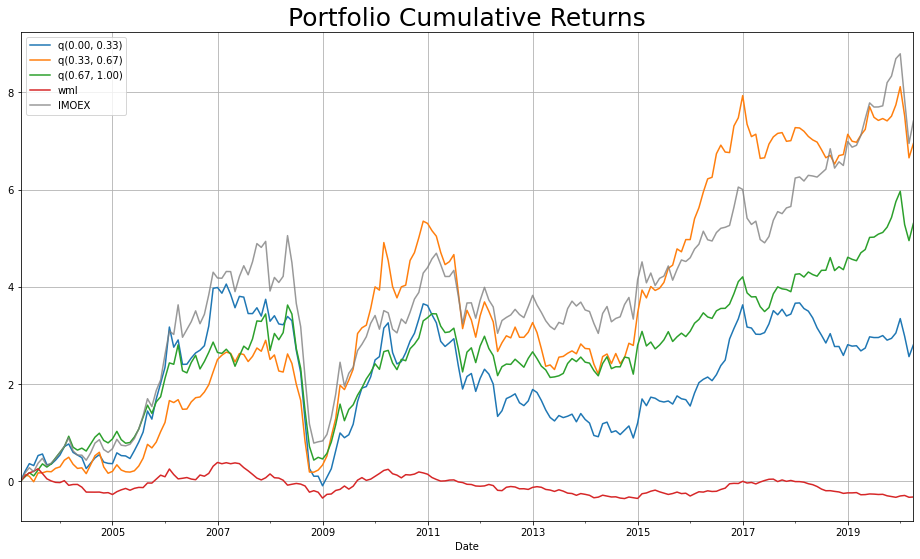

In [8]:
pqr.factor_model_tear_sheet(*portfolios, benchmark=benchmark)

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров.

In [9]:
%%time
%%capture

results = pqr.grid_search(
    stock_prices=prices,
    factor=mcap, # здесь передаем таблицу с сырыми данными, которые впоследствии будут преобразованы по-разному
    mask=liquidity_filter,
    is_dynamic=False,
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    benchmark=benchmark
)

CPU times: user 6.63 s, sys: 4.26 ms, total: 6.63 s
Wall time: 6.63 s


Теперь у нас есть словарь со статистикой для каждой модели. Посмотрим, что для нашей изначальной модели статистика все та же (с тем лишь исключением, что перебирали мы без WML-портфелей).

In [10]:
results[(3, 0, 3)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.30,0.12,-0.06
Beta,1.08,0.95,0.94
Sharpe Ratio,0.41,0.58,0.57
"Mean Return, %",1.09,1.35,1.16
"Volatility, %",9.20,8.06,7.03
"Excess Return, %",-0.21,0.04,-0.15
Benchmark Correlation,0.84,0.85,0.96
"Win Rate, %",55.12,58.05,60.00
"Maximum Drawdown, %",-145.64,-101.44,-103.51


На данный момент не реализован поиск лучшего портфеля по таргету, но его можно сделать самостоятельно довольно простой функцией. Найдем портфель с наибольшим коэффициентом Шарпа.

In [11]:
def find_best_model(results, target='Alpha, %'):
    model_params = None
    max_target = -np.inf
    best_portfolio = None
    for params, stats in results.items():
        max_value = stats.loc[target].max()
        if max_value > max_target:
            model_params = params
            best_portfolio = stats.columns[stats.loc[target].argmax()]
            max_target = max_value
    return model_params, best_portfolio

In [12]:
find_best_model(results, target='Sharpe Ratio')

((1, 0, 1), 'q(0.33, 0.67)')

У нас получилось, что лучшая модель имеет параметры 1-0-1, а портфель состоит из квантилей от 1/3 до 2/3. Построим такую модель.

In [13]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=pqr.Factor(mcap).look_back().prefilter(liquidity_filter),
    add_wml=True,
    quantiles=3
)

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml
"Alpha, %",-0.56,0.38,-0.07,0.49
Beta,1.11,0.93,0.95,-0.15
Sharpe Ratio,0.32,0.67,0.57,0.19
"Mean Return, %",0.88,1.60,1.17,0.29
"Volatility, %",9.41,8.21,7.13,5.29
"Excess Return, %",-0.43,0.29,-0.13,-1.01
Benchmark Correlation,0.84,0.81,0.96,-0.20
"Win Rate, %",54.59,60.39,59.42,54.11
"Maximum Drawdown, %",-161.96,-107.56,-107.28,-67.01


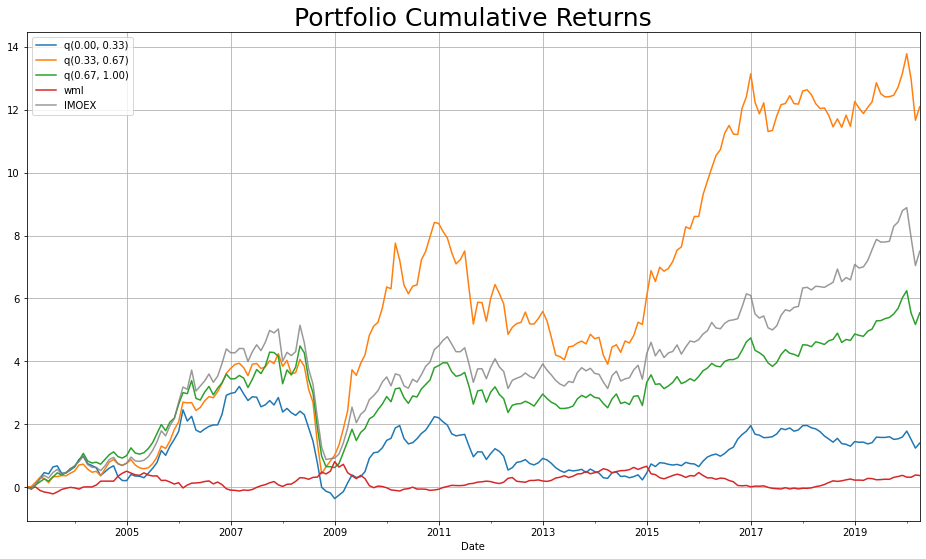

In [14]:
pqr.factor_model_tear_sheet(*portfolios, benchmark=benchmark)

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в список, нас интересует 2 элемент.

In [15]:
best_portfolio = portfolios[1]

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти на половину.

<AxesSubplot:xlabel='Date'>

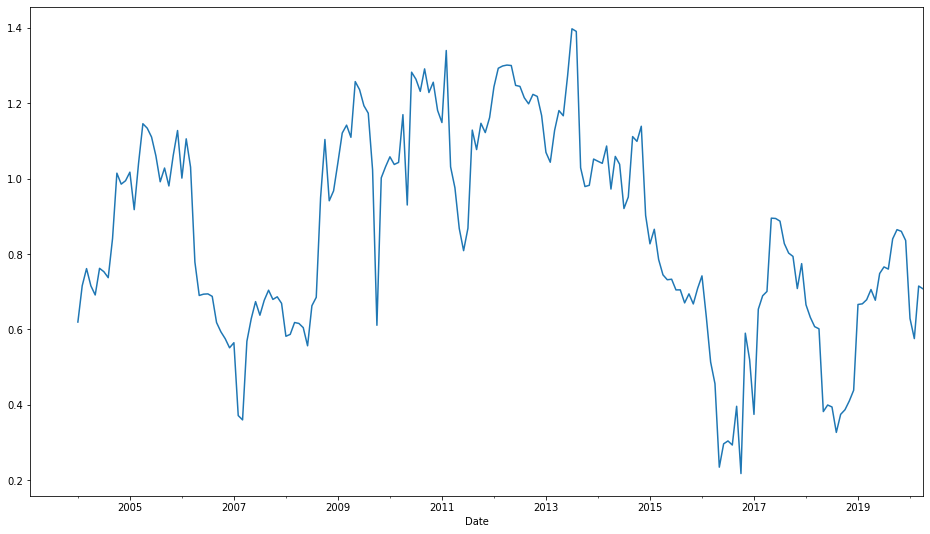

In [16]:
pqr.rolling_beta(best_portfolio.returns, benchmark.returns)[0].plot()

Годовой Шарп выглядит совсем непривлекательно - американские горки.

<AxesSubplot:xlabel='Date'>

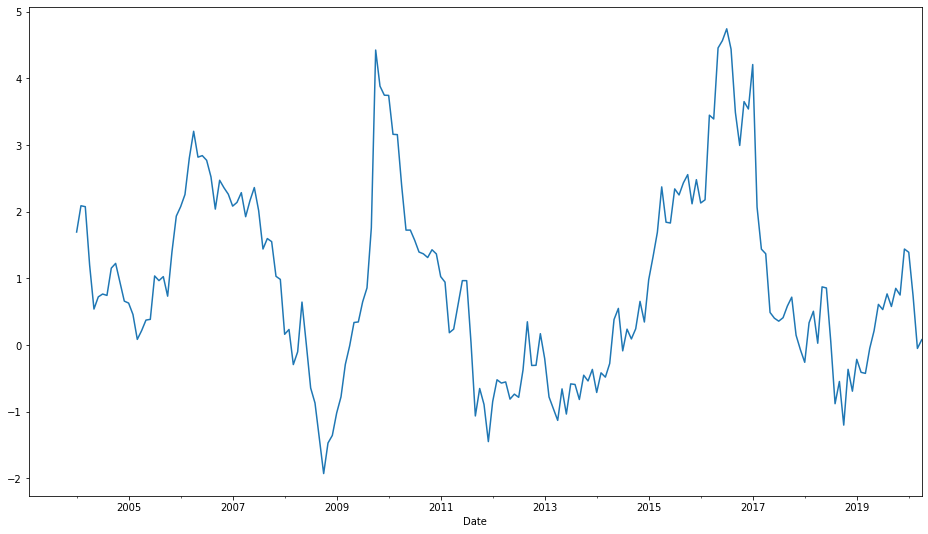

In [17]:
pqr.rolling_sharpe(best_portfolio.returns).plot()

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы всего портфеля, и даже чуть больше, поэтому окончательно отметаем данный портфель.

<AxesSubplot:xlabel='Date'>

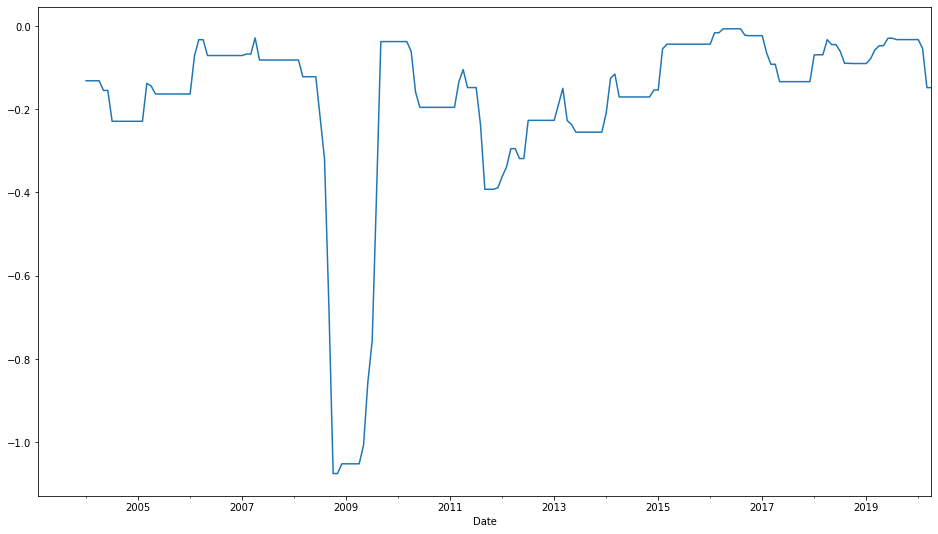

In [18]:
pqr.rolling_max_drawdown(best_portfolio.returns).plot()

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [19]:
# создадим 2 портфеля

# портфель, включающий в себя топ-10 акций по значению фактора
# для фактора размера это в действительности топ-10 худших компаний, т.е. топ-10 с наиболее высокой капитализацией
top10_portfolio = pqr.Portfolio('top-10')

# портфель, включающий 10% бумаг с наименьшим значением фактора
q01_portfolio = pqr.Portfolio('q-0.1')

In [20]:
# проинвестируем в оба в стратегию 3-0-3
top10_portfolio.pick_stocks_by_factor(
    factor=size,
    thresholds=(1, 10),
    method='top'
).weigh_equally().allocate(prices)


q01_portfolio.pick_stocks_by_factor(
    factor=size,
    thresholds=(0, 0.1),
    method='quantile'
).weigh_equally().allocate(prices);

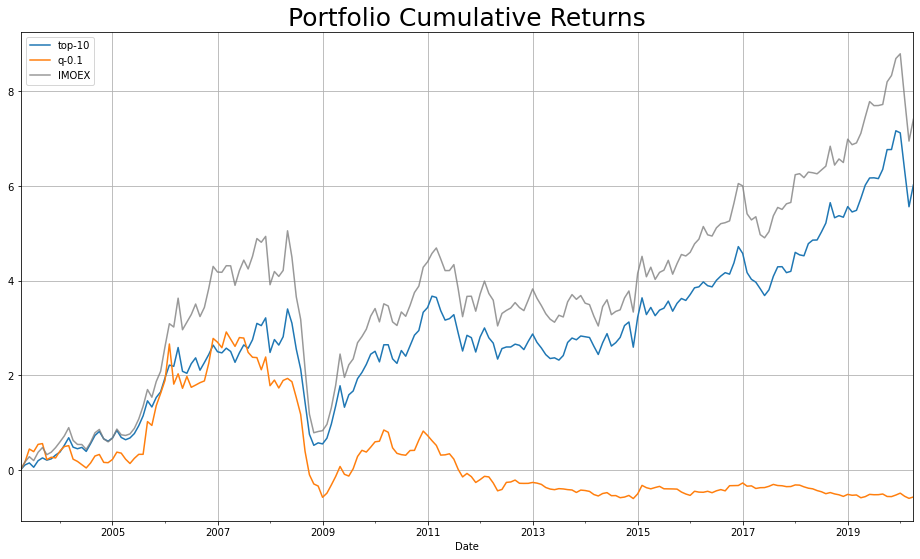

In [21]:
pqr.plot_cumulative_returns(top10_portfolio.returns, q01_portfolio.returns, benchmark_returns=benchmark.returns)

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

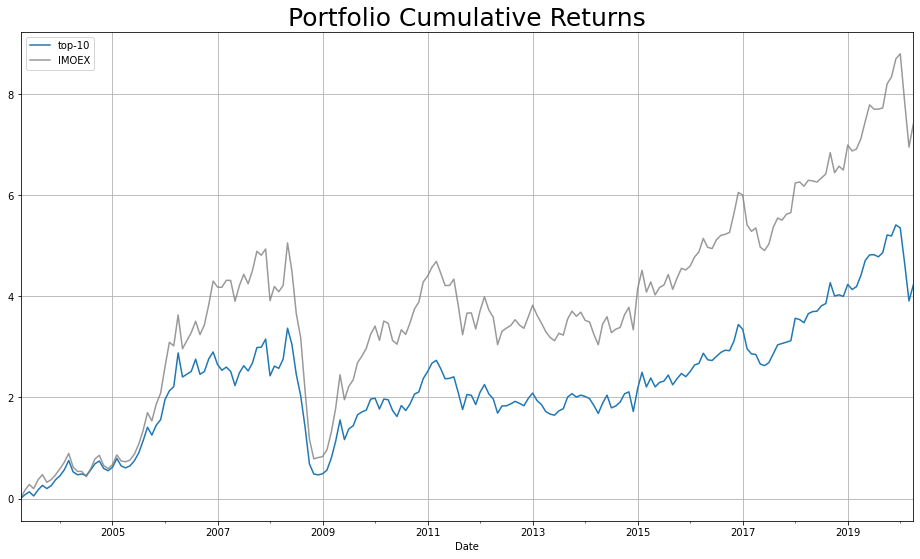

In [22]:
top10_portfolio.weigh_by_factor(size).allocate(prices)

pqr.plot_cumulative_returns(top10_portfolio.returns, benchmark_returns=benchmark.returns)

Как бы это не выглядело странным, но после перехода от равных весов к взвешиванию по капитализации, портфель довольно сильно отстал от бенчмарка. Попробуем, наоборот.

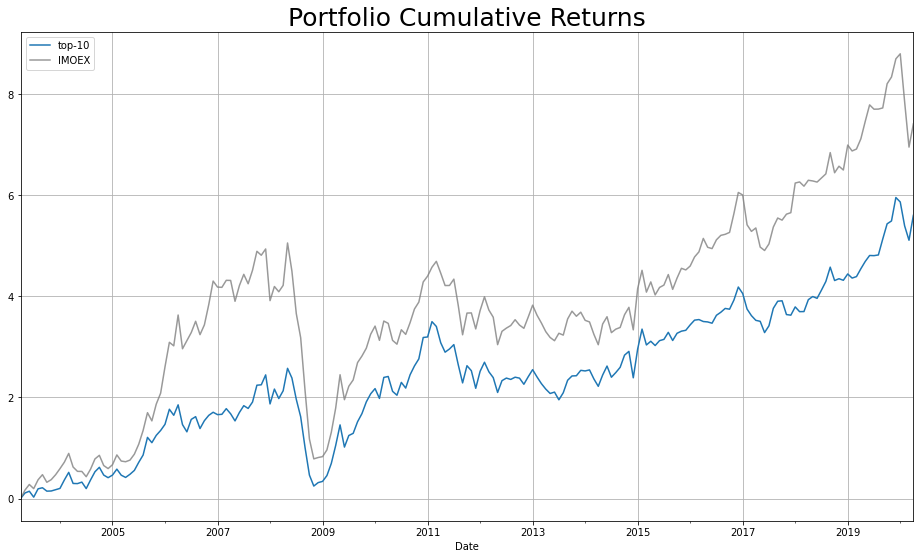

In [23]:
top10_portfolio.weigh_by_factor(
    pqr.Factor(1 / mcap).look_back()
).allocate(prices)

pqr.plot_cumulative_returns(top10_portfolio.returns, benchmark_returns=benchmark.returns)

Отставание от бенчмарка сократилось, но по-прежнему больше, чем при портфеле с равными весами. Обогнать бенчмарк на основе фактора размера на российском рынке не вышло, но это мы еще не пробовали другие параметры. Пока признаем поражение и посмотрим, что еще можно достать из портфеля.

## Немного аналитики по портфелю

Посмотрим, какие вообще компании в основном были в нашем портфеле. Абсолютными лидерами стали Сбербанк, Сургутнефтегаз, Норникель и Лукойл. Выглядит так, что они были в нашем портфеле вообще всегда.

<AxesSubplot:>

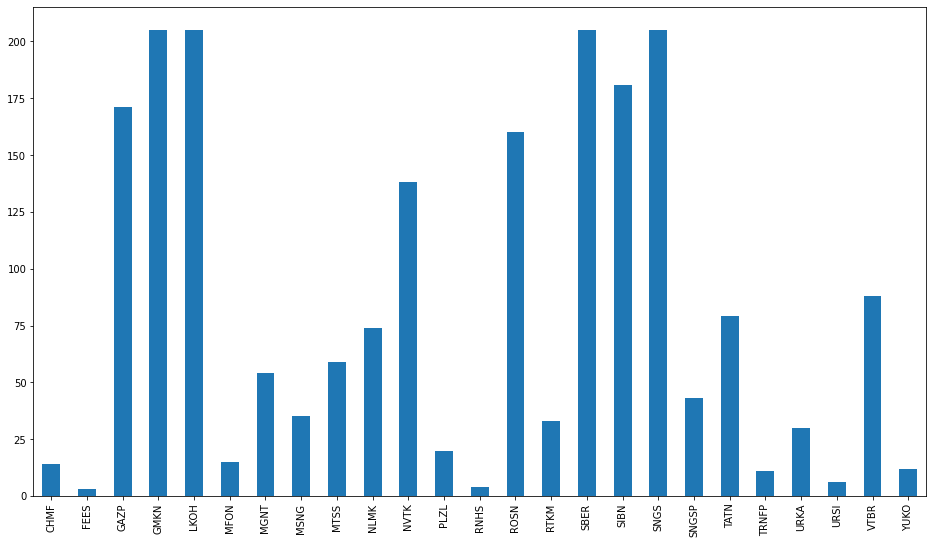

In [24]:
picks = top10_portfolio.picks
at_least_1_pick = (picks.sum() > 0)
picks[picks.columns[at_least_1_pick]].sum().plot.bar()

По графику прибыльных периодов видно, что вероятность прибыльного периода колеблется около 50%, но чаще все-таки выше.

<AxesSubplot:xlabel='Date'>

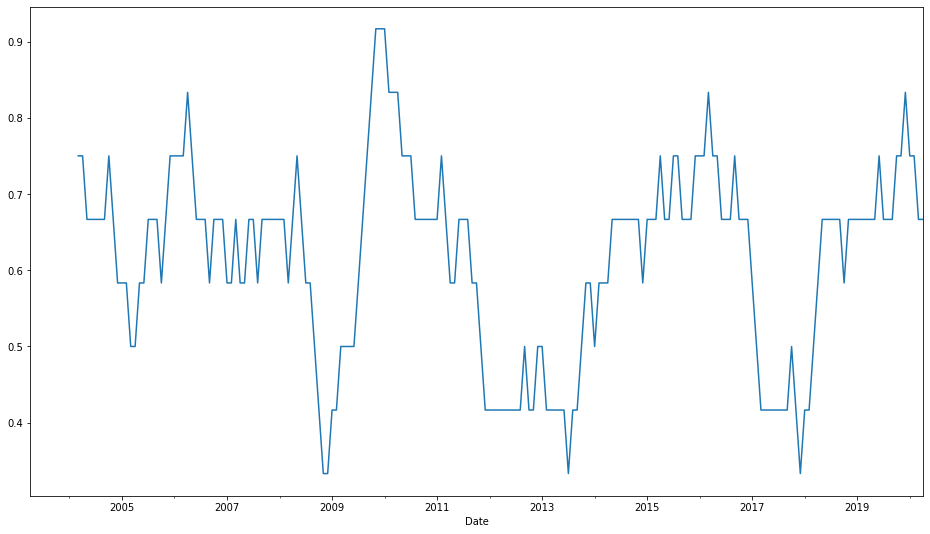

In [25]:
pqr.rolling_win_rate(top10_portfolio.returns).plot()

Также видно, что действительно портфель не обгоняет бенчмарк почти никогда.

<AxesSubplot:xlabel='Date'>

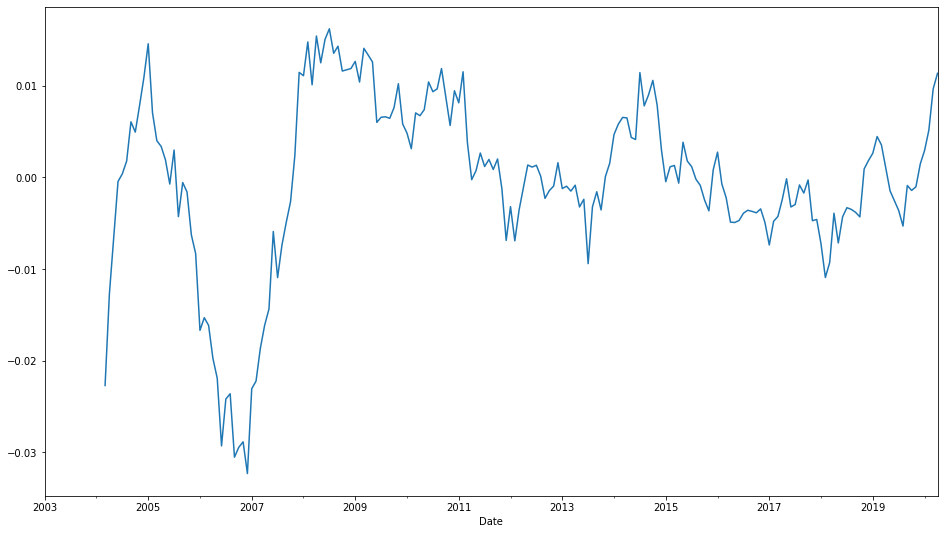

In [26]:
pqr.rolling_excess_return(top10_portfolio.returns, benchmark_returns=benchmark.returns).plot()

Посмотрим также на summary-статистики.

In [27]:
pqr.summary(top10_portfolio.returns, benchmark.returns)

Alpha, %                 -0.00
Beta                      0.93
Sharpe Ratio              0.57
Mean Return, %            1.19
Volatility, %             7.28
Excess Return, %         -0.11
Benchmark Correlation     0.91
Win Rate, %              61.46
Maximum Drawdown, %     -94.62
Name: top-10, dtype: float64

# Случайный тест

Суть теста заключается в том, что мы строим много (для примера 1000) случайных портфелей. Случайный портфели строятся так:
* сначала считаем, сколько акций мы купили в каждый период времени
* затем выбираем то же количество акций случайным образом для каждого периода
* повторяем это 1000 раз

Затем вспоминаем, что тестируем мы по таргету - метрике, которую мы хотим проанализировать для нашего портфеля. Считаем метрику у всех 1000 случайных портфелей, получилось распределение случайной величины - метрики. Берем несколько (для примера 5) квантилей этой случайной величины, и отбираем только те портфели, которые являются пограничными для каждого квантиля по этой метрике. На выходе получаем столбец из значений метрики-таргета и массив портфелей, соответствующих значениям. Можем отрисовать их кумулятивные доходности, например.

Есть одна проблема: таргет - это любая функция, которая на вход принимает портфель, и возвращает число. Благодаря этому вы можете написать свою метрику и запросто провести тест на ее основе. Однако минус данного подхода в том, что нельзя напрямую запихнуть метрики, для расчета которых необходим бенчмарк.

In [28]:
import functools as ft

# но в этом нам поможет встроенный в python модуль functools
# в нем есть функция partial, которая принимает на вход функцию и аргументы, которые необходимо зафиксировать
# зафиксируем бенчмарк для расчета альфы, и готово: теперь наша новая функция 
target_alpha = ft.partial(pqr.alpha, benchmark_returns=benchmark.returns)

In [29]:
%%time
%%capture

target_values, random_portfolios = pqr.zero_intelligence_test(
    prices, top10_portfolio, target_alpha, quantiles=5,
    n=1000, mask=liquidity_filter
)

CPU times: user 26 s, sys: 280 ms, total: 26.3 s
Wall time: 26.3 s


In [30]:
target_values

388   -0.006049
0     -0.000866
145    0.002599
151    0.003959
844    0.006357
dtype: float64

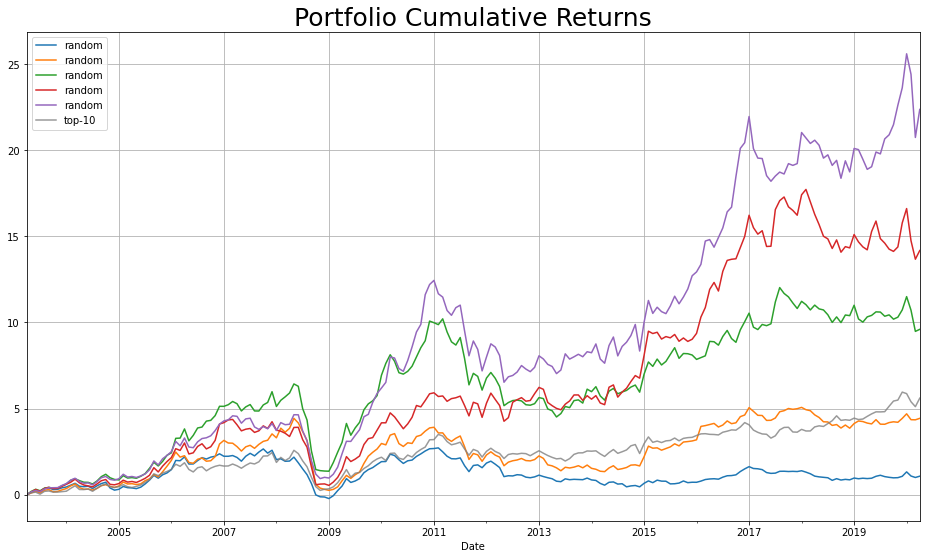

In [31]:
pqr.plot_cumulative_returns(
    *[rp.returns for rp in random_portfolios], benchmark_returns=top10_portfolio.returns
)